In [1]:
!pip -q install opencv-python matplotlib torch torchvision
!pip -q install git+https://github.com/facebookresearch/segment-anything.git

import os, urllib.request

os.makedirs("checkpoints", exist_ok=True)

# ViT-H checkpoint (best quality, slower). You can swap to ViT-B for speed.
ckpt_path = "checkpoints/sam_vit_h_4b8939.pth"
if not os.path.exists(ckpt_path):
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    print("Downloading SAM checkpoint...")
    urllib.request.urlretrieve(url, ckpt_path)
    print("Done:", ckpt_path)
else:
    print("Checkpoint already exists:", ckpt_path)

  Preparing metadata (setup.py) ... done
Done: checkpoints/sam_vit_h_4b8939.pth


Saving rice-south-10-24-25.jpg to rice-south-10-24-25.jpg


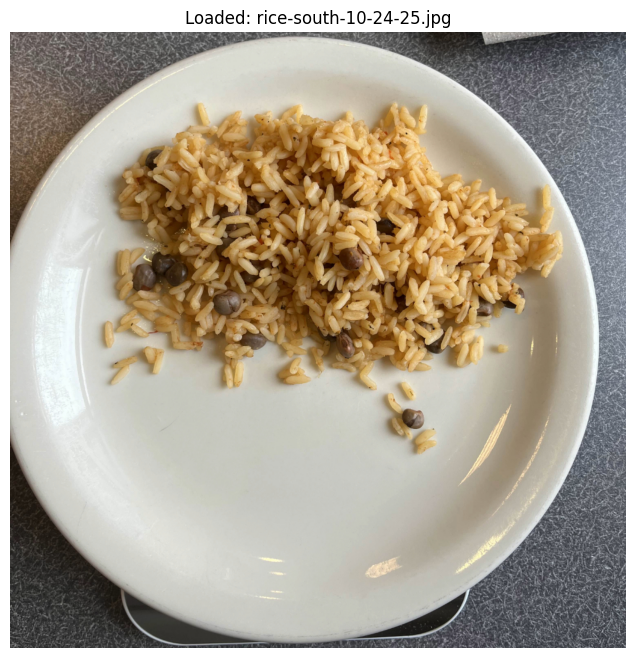

In [2]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))  # first uploaded file

# Read with OpenCV (BGR), convert to RGB for display/model
image_bgr = cv2.imread(img_path)
if image_bgr is None:
    raise FileNotFoundError(f"Could not read {img_path}")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(image_rgb)
plt.title(f"Loaded: {img_path}")
plt.axis("off")
plt.show()

In [3]:
import torch
from segment_anything import sam_model_registry, SamPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

sam = sam_model_registry["vit_h"](checkpoint=ckpt_path)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image_rgb)
print("SAM ready.")

Device: cuda
SAM ready.


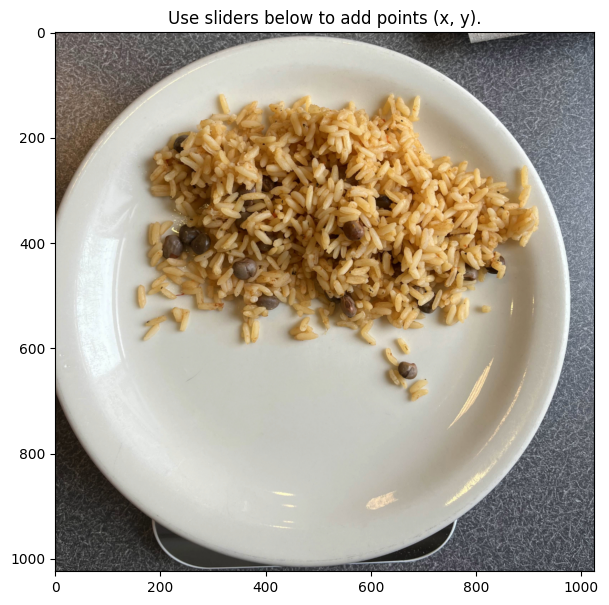

Image size (H, W): (1024, 1024)


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(image_rgb)
plt.title("Use sliders below to add points (x, y).")
plt.axis("on")  # keep axes so you can visually match x/y
plt.show()

print("Image size (H, W):", image_rgb.shape[:2])

In [8]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

H, W = image_rgb.shape[:2]

pos_points = []
neg_points = []

x = widgets.IntSlider(min=0, max=W-1, description="x", continuous_update=False)
y = widgets.IntSlider(min=0, max=H-1, description="y", continuous_update=False)

add_pos = widgets.Button(description="Add + (food)", button_style="success")
add_neg = widgets.Button(description="Add - (not food)", button_style="danger")
undo = widgets.Button(description="Undo last")
clear = widgets.Button(description="Clear")
done = widgets.Button(description="Print points")

out = widgets.Output()

def redraw():
    with out:
        out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(image_rgb)
        for px, py in pos_points:
            ax.plot(px, py, "g*", markersize=12)
        for px, py in neg_points:
            ax.plot(px, py, "r*", markersize=12)
        ax.set_title("Green = + food, Red = - not food")
        ax.axis("off")
        plt.show()
        print("pos_points:", pos_points)
        print("neg_points:", neg_points)

def on_add_pos(_):
    pos_points.append((x.value, y.value))
    redraw()

def on_add_neg(_):
    neg_points.append((x.value, y.value))
    redraw()

def on_undo(_):
    if neg_points and (not pos_points or len(neg_points) > len(pos_points)):
        neg_points.pop()
    elif pos_points:
        pos_points.pop()
    redraw()

def on_clear(_):
    pos_points.clear()
    neg_points.clear()
    redraw()

def on_done(_):
    with out:
        print("FINAL pos_points =", pos_points)
        print("FINAL neg_points =", neg_points)

add_pos.on_click(on_add_pos)
add_neg.on_click(on_add_neg)
undo.on_click(on_undo)
clear.on_click(on_clear)
done.on_click(on_done)

display(widgets.VBox([
    widgets.HBox([x, y]),
    widgets.HBox([add_pos, add_neg, undo, clear, done]),
    out
]))

redraw()


In [13]:
print("Positive points:", pos_points)
print("Negative points:", neg_points)

Positive points: [(500, 350), (500, 450), (600, 450), (600, 190)]
Negative points: [(506, 729), (980, 699)]


In [14]:
import numpy as np

if len(pos_points) == 0:
    raise ValueError("Add at least one positive (+) point on the food.")

points = np.array(pos_points + neg_points, dtype=np.float32)
labels = np.array([1]*len(pos_points) + [0]*len(neg_points), dtype=np.int32)

masks, scores, _ = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=True,
)

best_idx = int(np.argmax(scores))
best_mask = masks[best_idx].astype(bool)

print("SAM scores:", scores, "best:", best_idx)


SAM scores: [0.56541955 0.92982566 0.9684274 ] best: 2


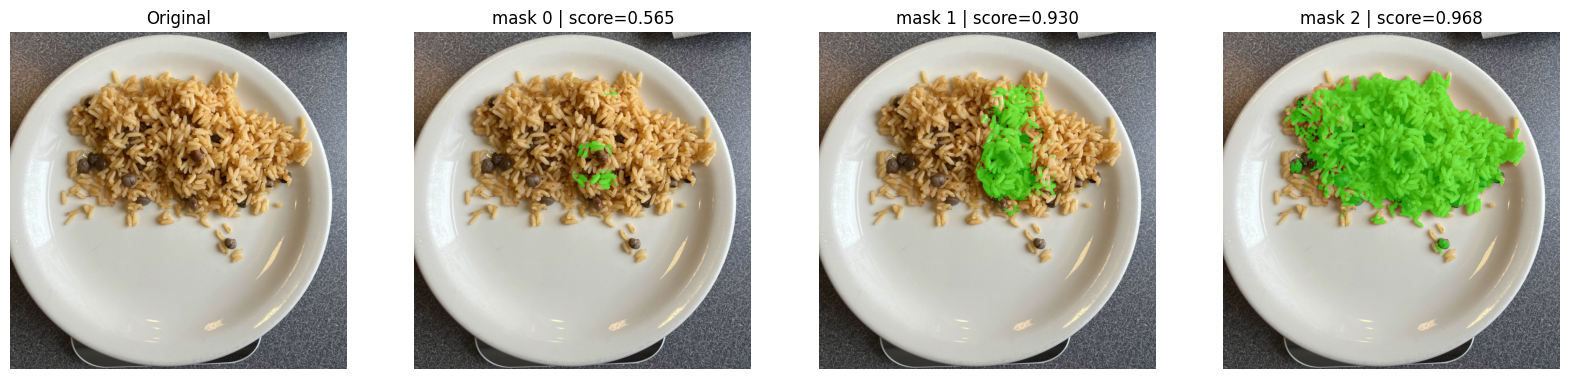

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_mask(image_rgb, mask, alpha=0.5):
    out = image_rgb.copy()
    color = np.array([0, 255, 0], dtype=np.uint8)
    out[mask] = (out[mask] * (1 - alpha) + color * alpha).astype(np.uint8)
    return out

fig, axs = plt.subplots(1, len(masks)+1, figsize=(5*(len(masks)+1), 5))

# Original
axs[0].imshow(image_rgb, origin="upper")
axs[0].set_title("Original")
axs[0].axis("off")

# Each candidate
for i in range(len(masks)):
    axs[i+1].imshow(overlay_mask(image_rgb, masks[i].astype(bool)), origin="upper")
    axs[i+1].set_title(f"mask {i} | score={scores[i]:.3f}")
    axs[i+1].axis("off")

plt.show()

In [16]:
import numpy as np

H, W = image_rgb.shape[:2]

for i in range(len(masks)):
    m = masks[i].astype(bool)
    area = int(m.sum())
    print(f"mask {i}: area={area} pixels ({area/(H*W)*100:.2f}%) score={scores[i]:.3f}")

mask 0: area=6210 pixels (0.59%) score=0.565
mask 1: area=47100 pixels (4.49%) score=0.930
mask 2: area=206103 pixels (19.66%) score=0.968


# DPT

In [17]:
import torch
import cv2
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

model_type = "DPT_Large"  # best quality; use DPT_Hybrid if memory issues

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transforms.dpt_transform

device: cuda


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:37<00:00, 37.0MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [18]:
# image_rgb is HxWx3 uint8
input_batch = transform(image_rgb).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

depth = prediction.squeeze().cpu().numpy()

# Resize to original image size
depth = cv2.resize(depth, (image_rgb.shape[1], image_rgb.shape[0]))

print("Depth map shape:", depth.shape)

Depth map shape: (1024, 1024)


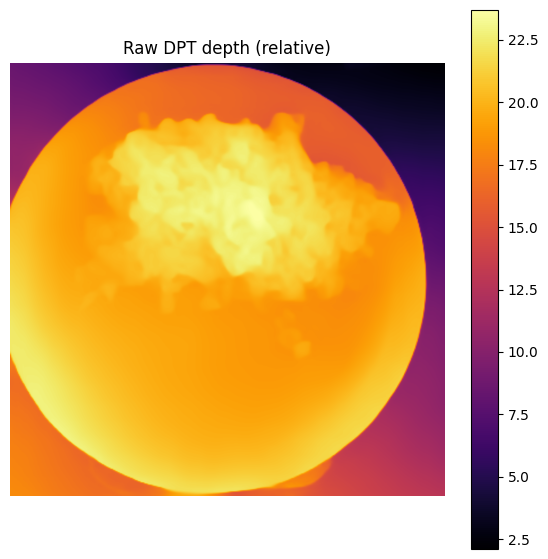

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(depth, cmap="inferno")
plt.title("Raw DPT depth (relative)")
plt.colorbar()
plt.axis("off")
plt.show()

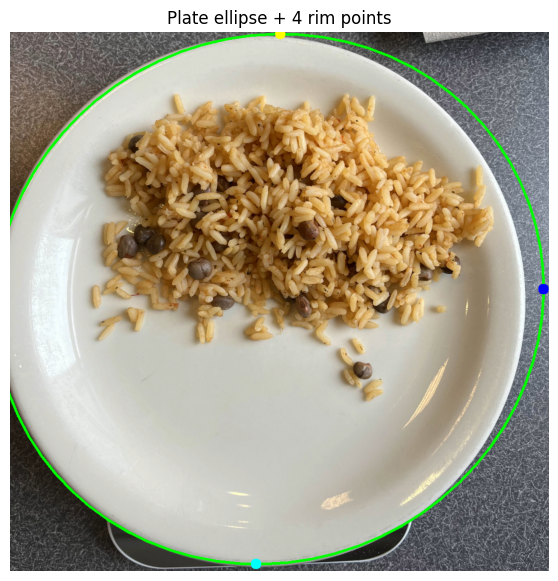

Ellipse (cx,cy) = (492.100830078125, 506.93670654296875) axes(px) = (997.2796020507812, 1052.2486572265625) angle = 64.81441497802734


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = image_rgb.copy()
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Plate is bright; threshold + clean
_, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
th = cv2.medianBlur(th, 7)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find largest contour (plate)
cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

plate_cnt = None
for c in cnts[:5]:
    if cv2.contourArea(c) > 0.05 * img.shape[0] * img.shape[1]:
        plate_cnt = c
        break
if plate_cnt is None:
    raise RuntimeError("Could not find plate contour. Try adjusting thresholding.")

if len(plate_cnt) < 5:
    raise RuntimeError("Not enough points to fit ellipse.")

ellipse = cv2.fitEllipse(plate_cnt)  # ((cx,cy),(major,minor),angle)
(cx, cy), (MA, ma), angle = ellipse

# Get 4 extremal points on the fitted ellipse
# We'll sample the ellipse param and pick min/max x/y
theta = np.linspace(0, 2*np.pi, 500)
a = MA / 2.0
b = ma / 2.0
phi = np.deg2rad(angle)

xs = cx + a*np.cos(theta)*np.cos(phi) - b*np.sin(theta)*np.sin(phi)
ys = cy + a*np.cos(theta)*np.sin(phi) + b*np.sin(theta)*np.cos(phi)

pts = np.stack([xs, ys], axis=1)

left  = pts[np.argmin(pts[:,0])]
right = pts[np.argmax(pts[:,0])]
top   = pts[np.argmin(pts[:,1])]
bot   = pts[np.argmax(pts[:,1])]

rim4 = np.stack([left, right, top, bot], axis=0).astype(np.float32)

# Visualize
viz = img.copy()
cv2.ellipse(viz, ellipse, (0,255,0), 3)
for p, col in zip(rim4, [(255,0,0),(0,0,255),(255,255,0),(0,255,255)]):
    cv2.circle(viz, (int(p[0]), int(p[1])), 10, col, -1)

plt.figure(figsize=(7,7))
plt.imshow(viz)
plt.title("Plate ellipse + 4 rim points")
plt.axis("off")
plt.show()

print("Ellipse (cx,cy) =", (cx,cy), "axes(px) =", (MA, ma), "angle =", angle)

In [21]:
plate_diameter_cm = 26.0  # <-- set this

diameter_px = 0.5*(MA + ma)  # average of major/minor as a rough diameter
px_per_cm = diameter_px / plate_diameter_cm
cm_per_px = 1.0 / px_per_cm

print("diameter_px:", diameter_px)
print("px_per_cm:", px_per_cm, "cm_per_px:", cm_per_px)


diameter_px: 1024.7641296386719
px_per_cm: 39.41400498610277 cm_per_px: 0.02537169212701415


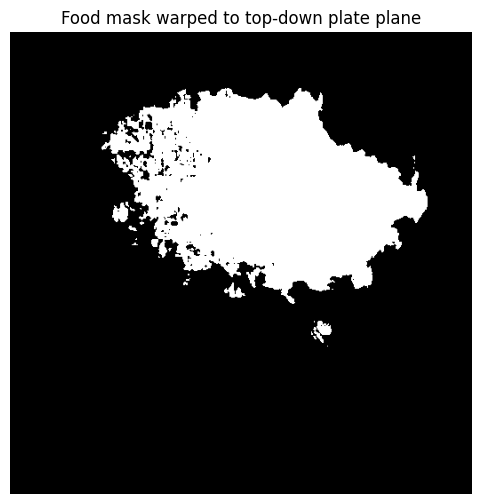

Top-down area per pixel (cm^2): 0.0025000000000000005


In [22]:
R = plate_diameter_cm / 2.0  # cm

# Define circle points in "plate plane" coords (cm)
dst4 = np.array([
    [-R,  0],  # left
    [ R,  0],  # right
    [ 0, -R],  # top
    [ 0,  R],  # bottom
], dtype=np.float32)

# Homography from image -> plate-plane coordinates
H_img2plane, _ = cv2.findHomography(rim4, dst4, method=0)
if H_img2plane is None:
    raise RuntimeError("Homography failed")

# For warping we need plane -> image, so invert:
H_plane2img = np.linalg.inv(H_img2plane)

# Choose output resolution in cm-per-pixel for the top-down plane
cm_per_px_plane = 0.05  # 0.05 cm = 0.5mm per pixel (adjust for speed/quality)
out_size = int((plate_diameter_cm / cm_per_px_plane))
out_size = max(out_size, 256)

# Define warp to top-down image coordinates:
# We want plane coords [-R..R] -> image pixels [0..out_size)
S = np.array([
    [1/cm_per_px_plane, 0,              out_size/2],
    [0,              1/cm_per_px_plane, out_size/2],
    [0,              0,              1]
], dtype=np.float64)

# Final homography mapping image -> topdown pixels
H_img2top = S @ H_img2plane

# Warp mask into top-down
mask_top = cv2.warpPerspective(
    (best_mask.astype(np.uint8)*255),
    H_img2top,
    (out_size, out_size),
    flags=cv2.INTER_NEAREST
) > 0

plt.figure(figsize=(6,6))
plt.imshow(mask_top, cmap="gray")
plt.title("Food mask warped to top-down plate plane")
plt.axis("off")
plt.show()

area_per_pixel_cm2 = (cm_per_px_plane ** 2)
print("Top-down area per pixel (cm^2):", area_per_pixel_cm2)


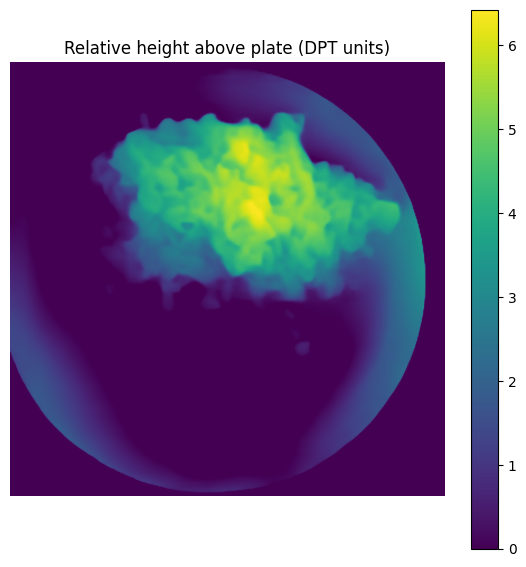

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

H, W = depth.shape

# plate pixels = inside plate contour AND not food
plate_mask_img = np.zeros((H, W), dtype=np.uint8)
cv2.drawContours(plate_mask_img, [plate_cnt], -1, 1, thickness=-1)

bg_plate = (plate_mask_img.astype(bool)) & (~best_mask.astype(bool))

ys, xs = np.where(bg_plate)
z = depth[ys, xs]

# Fit a simple 2D quadratic surface z = ax^2 + by^2 + cxy + dx + ey + f
X = np.stack([xs**2, ys**2, xs*ys, xs, ys, np.ones_like(xs)], axis=1).astype(np.float64)
coef, *_ = np.linalg.lstsq(X, z.astype(np.float64), rcond=None)

# Predict plate surface everywhere
grid_y, grid_x = np.mgrid[0:H, 0:W]
Xg = np.stack([grid_x**2, grid_y**2, grid_x*grid_y, grid_x, grid_y, np.ones_like(grid_x)], axis=2)
plate_surface = (Xg @ coef).astype(np.float32)

# DPT: brighter often means closer. Your map shows food is brighter.
# So "height_rel" should be positive where food rises above plate:
height_rel = depth - plate_surface
height_rel = np.clip(height_rel, 0, None)

plt.figure(figsize=(7,7))
plt.imshow(height_rel, cmap="viridis")
plt.title("Relative height above plate (DPT units)")
plt.colorbar()
plt.axis("off")
plt.show()

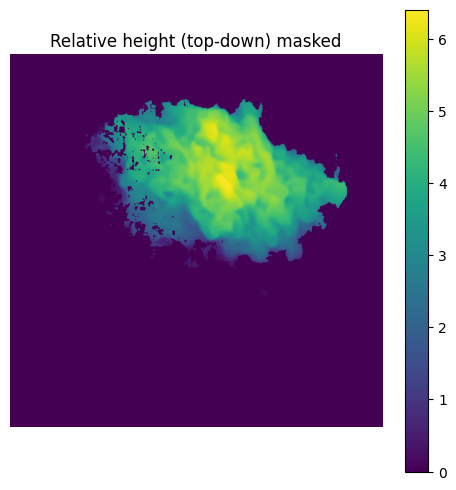

In [24]:
height_top = cv2.warpPerspective(
    height_rel.astype(np.float32),
    H_img2top,
    (out_size, out_size),
    flags=cv2.INTER_LINEAR
)

# Only keep food region
height_top_food = np.clip(height_top, 0, None) * mask_top

plt.figure(figsize=(6,6))
plt.imshow(height_top_food, cmap="viridis")
plt.title("Relative height (top-down) masked")
plt.colorbar()
plt.axis("off")
plt.show()


In [25]:
volume_rel = float(height_top_food.sum() * area_per_pixel_cm2)
print("Relative volume (cm^2 * DPT_units):", volume_rel)

Relative volume (cm^2 * DPT_units): 500.2398986816406


In [26]:
k_cm_per_unit = 0.15  # <-- you must calibrate this once
volume_cm3 = float((height_top_food * k_cm_per_unit).sum() * area_per_pixel_cm2)
print("Estimated volume (cm^3):", volume_cm3)

Estimated volume (cm^3): 75.0359878540039
